# Convolutional Neural Network

Let's practice CNN by training the model to predict the number of coins in each image.

In [33]:
# Define random seed

import numpy as np
import torch

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [34]:
import kagglehub

path_to_dataset = kagglehub.dataset_download("balabaskar/count-coins-image-dataset")
print("Path to dataset files:", path_to_dataset)

Path to dataset files: /home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1


In [35]:
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

from lightning.pytorch.callbacks import TQDMProgressBar
from lightning.pytorch import LightningDataModule
from lightning.pytorch import LightningModule
import lightning.pytorch as L

print(L.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

2.5.2


In [36]:
csv_path = os.path.join(path_to_dataset, 'coins_count_values.csv')
df = pd.read_csv(csv_path)
display(df[0:3])

# map image_name to coins_count
img2ct = df.set_index("image_name")["coins_count"].to_dict()

,folder,image_name,coins_count
0,all_coins,01207e3d7e.jpg,5
1,all_coins,0140acf6eb.jpg,4
2,all_coins,025c8579f0.jpg,2


In [37]:
coins_dir = os.path.join(path_to_dataset, 'coins_images/coins_images')
print(coins_dir)
path_label = []
for dirpath, _, filenames in os.walk(coins_dir):
    if len(filenames) > 0:
        folder_name = os.path.basename(dirpath)
        print(f"Found {len(filenames)} images in {folder_name}")
        for filename in filenames:
            path = (os.path.join(dirpath, filename))
            label = img2ct[filename]
            path_label += [(path, label)]

print(path_label[0:3])
print("Total # of samples:", len(path_label))

/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images
Found 184 images in peso_coins
Found 211 images in yen_coins
Found 215 images in all_coins
Found 173 images in us_coins
Found 231 images in euro_coins
Found 220 images in indian_coins
Found 210 images in china_coins
[('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/0c0ea30f84.jpg', 6), ('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/61666fe63c.jpg', 5), ('/home/lazuward/.cache/kagglehub/datasets/balabaskar/count-coins-image-dataset/versions/1/coins_images/coins_images/peso_coins/af48e3a674.jpg', 1)]
Total # of samples: 1444


In [38]:
def get_mean_std(path_label):
    _transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    path_list = [e[0] for e in path_label]
    R = []
    G = []
    B = []
    for path in path_list:
        img = Image.open(path).convert('RGB')
        img = _transform(img)
        # reshape from (H x W x C) to (C x H x W)
        tensor = np.moveaxis(img.numpy(), -1, 0)
        R.append(tensor[0])
        G.append(tensor[1])
        B.append(tensor[2])
    R = np.stack(R, axis=0)
    G = np.stack(G, axis=0)
    B = np.stack(B, axis=0)
    mean = np.array([np.mean(R), np.mean(G), np.mean(B)])
    std = np.array([np.std(R), np.std(G), np.std(B)])
    return mean, std


mean, std = get_mean_std(path_label)
print(f"Mean: {mean.tolist()}")
print(f"Std: {std.tolist()}")

Mean: [0.6872422099113464, 0.685499906539917, 0.6830970048904419]
Std: [0.3176698088645935, 0.3171362280845642, 0.31665119528770447]


In [39]:
from torch.utils import data


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label


class DataModule(LightningDataModule):
    def __init__(self, path_label, mean, std, batch_size=32, seed=None):
        super().__init__()
        self.path_label = path_label
        self.batch_size = batch_size

        if seed is None:
            self.generator = torch.default_generator
        else:
            self.generator = torch.Generator().manual_seed(seed)

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        self.train = None
        self.val = None
        self.test = None

    def setup(self, stage=None):
        dataset = CustomDataset(self.path_label, self.transform)
        self.train, self.val, self.test = data.random_split(dataset, [0.8, 0.1, 0.1], self.generator)

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            generator=self.generator,
            shuffle=True,
            num_workers=8,
            pin_memory=True
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(self.val, batch_size=self.batch_size, generator=self.generator)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.test, batch_size=self.batch_size, generator=self.generator)

    def __len__(self):
        if self.train is not None:
            return len(self.train)
        elif self.val is not None:
            return len(self.val)
        elif self.test is not None:
            return len(self.test)
        else:
            return 0


datamodule = DataModule(path_label=path_label, mean=mean, std=std, seed=seed)
datamodule.setup()

In [40]:
class CustomProgressBar(TQDMProgressBar):
    def __init__(self):
        super().__init__()

    def init_validation_tqdm(self):
        bar = super().init_validation_tqdm()
        bar.disable = True
        return bar

    def on_validation_start(self, trainer, pl_module):
        pass

    def on_validation_epoch_start(self, trainer, pl_module):
        pass

    def on_validation_batch_start(self, trainer, pl_module, batch, batch_idx, dataloader_idx=0):
        pass

    def on_validation_end(self, trainer, pl_module):
        pass

    def on_validation_epoch_end(self, trainer, pl_module):
        pass

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        pass


def get_trainer():
    early_stopping = L.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=False,
        mode="min", check_on_train_epoch_end=False
    )
    tqdm_progress_bar = CustomProgressBar()
    trainer = L.Trainer(
        max_epochs=50,
        check_val_every_n_epoch=5,
        deterministic=True,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        callbacks=[early_stopping, tqdm_progress_bar],
    )
    return trainer


def save_checkpoint(trainer, model_name: str) -> str:
    ckpt_dir = "checkpoints"
    ckpt_path = os.path.join(ckpt_dir, f"{model_name}.ckpt")
    os.makedirs(ckpt_dir, exist_ok=True)
    trainer.save_checkpoint(ckpt_path)
    return ckpt_path

## CNN v1

Here we have stacked multiple layers of `nn.Conv2d` and `nn.Linear` in the model.

The model learns the spatial feature of each coin in an image to produce a number.

The goal is to output a number that matches the number of coins in the image.

In [41]:
from math import sqrt


class CNNv1(LightningModule):

    def __init__(self):
        super(CNNv1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 1)

    def forward(self, X):
        # K: number of kernels, F: filter size, S: stride
        # I=(3,224,224)
        # K=6, F=3, S=1, O=(6,222,222)
        X = F.relu(self.conv1(X))

        # F=2, S=2, O=(6,111,111)
        X = F.max_pool2d(X, 2, 2)

        # K=16, F=3, S=1, O=(16,109,109)
        X = F.relu(self.conv2(X))

        # F=2, S=2, O=(16,54,54)
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)

        # I=(16,54,54), O=120
        X = F.relu(self.fc1(X))

        # I=120, O=84
        X = F.relu(self.fc2(X))

        # I=84, O=20
        X = F.relu(self.fc3(X))

        # I=20, O=1
        X = self.fc4(X)

        # reshape (N,1) to N, where N = batch_size
        return X.squeeze(1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        mse_loss = F.mse_loss(y_hat, y.float())
        rmse_loss = sqrt(mse_loss.item())
        self.log("mse_loss", mse_loss)  # mean squared error
        self.log("rmse_loss", rmse_loss)  # root mean squared error


In [42]:
model = CNNv1()

In [43]:
trainer = get_trainer()
trainer.fit(model, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 21     | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.447    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 37/37 [00:03<00:00, 11.49it/s, v_num=83]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 37/37 [00:03<00:00, 11.48it/s, v_num=83]


In [44]:
ckpt_path = save_checkpoint(trainer, f"cnn-v1-seed-{seed}")

In [45]:
model = CNNv1.load_from_checkpoint(ckpt_path)

In [46]:
trainer = get_trainer()
trainer.test(model, dataloaders=datamodule.test_dataloader())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        mse_loss             74.2347183227539
        rmse_loss            5.897542953491211
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mse_loss': 74.2347183227539, 'rmse_loss': 5.897542953491211}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1633854..1.0007952].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


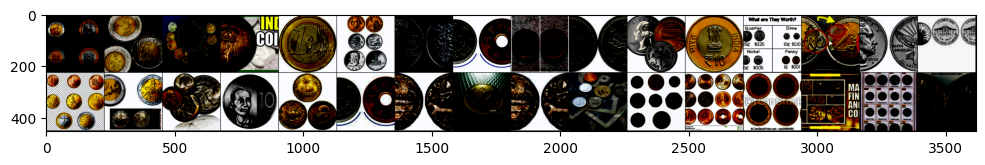

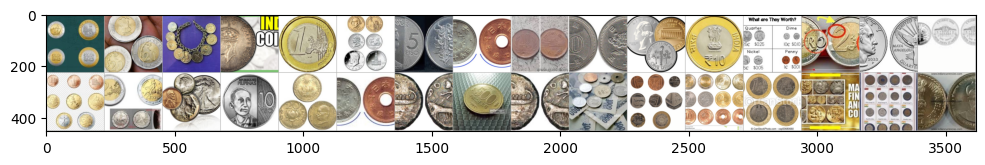

In [47]:
images, labels = next(iter(datamodule.test_dataloader()))
im = make_grid(images, nrow=16)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

inv_normalize = transforms.Normalize(mean=-mean / std, std=1 / std)
im = inv_normalize(im)

plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [48]:
import matplotlib.pyplot as plt


def get_predict_true_pair(model) -> tuple:
    model.eval()
    _y_true = []
    _y_pred = []
    with torch.no_grad():
        cpu_device = torch.device("cpu")
        for test_data in datamodule.test_dataloader():
            test_images, test_labels = test_data[0].to(cpu_device), test_data[1].to(cpu_device)
            pred = model(test_images)
            for i in range(len(pred)):
                _y_true.append(test_labels[i].item())
                _y_pred.append(pred[i].item())
    return _y_true, _y_pred


def visualize_prediction(model):
    y_true, y_pred = get_predict_true_pair(model)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Scatter Plot of True vs Predicted (Coin Counts)")
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.grid(True)
    plt.show()

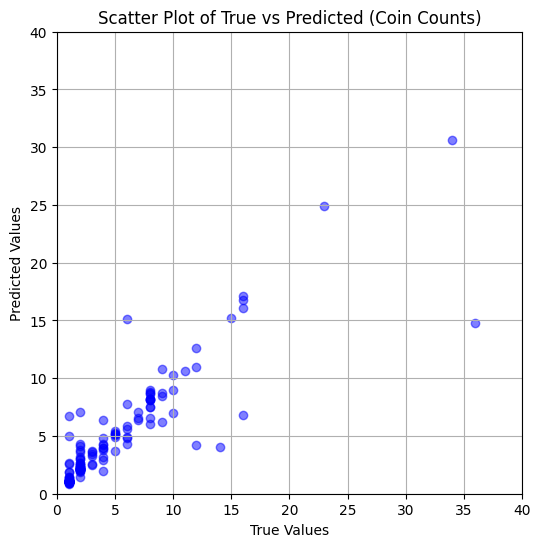

In [49]:
visualize_prediction(model)

## Evaluation
Feeding the same dataset is crucial to keep the experiment consistent and reliable.

We use a pseudo-random generator with arbitrary seed to keep the model's behavior consistent and deterministic for each run.

With `seed=0`, CNNv1 has $MSE = 18.8$, giving an expectation that the model would **miss ~4 coins per image** by average.

One might argue that it's unfair to judge the model this way because the number of coins varies greatly across the images.

However, it's clearly obvious in the plot above that the model is overfitted to some degree.

## CNN v2

- One more layer of receptive field
- Introduce batch normalization
- Introduce dropout regularization during affine transformation

In [57]:
import math


class CNNv2(LightningModule):

    def __init__(self, dropout=0.2):
        super(CNNv2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=8)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)

        self.fc1 = nn.Linear(in_features=32 * 28 * 28, out_features=128)
        self.dropout1 = nn.Dropout(p=dropout)

        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.dropout2 = nn.Dropout(p=dropout)

        self.fc3 = nn.Linear(in_features=64, out_features=8)
        self.dropout3 = nn.Dropout(p=dropout)

        self.fc4 = nn.Linear(in_features=8, out_features=1)

    def forward(self, X):
        # B x 3 x 224 x 224
        X = self.conv1(X)
        X = F.relu(self.bn1(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 8 x 112 x 112
        X = self.conv2(X)
        X = F.relu(self.bn2(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 16 x 56 x 56
        X = self.conv3(X)
        X = F.relu(self.bn3(X))
        X = F.max_pool2d(X, 2, 2)

        # B x 32 x 28 x 28
        X = X.view(-1, 32 * 28 * 28)
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)

        # B x 128
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)

        # B x 64
        X = F.relu(self.fc3(X))
        X = self.dropout3(X)

        # B x 8
        X = F.relu(self.fc4(X))

        # B x 1
        return X.squeeze(1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = F.mse_loss(y_hat, y.float())
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        mse_loss = F.mse_loss(y_hat, y.float())
        rmse_loss = sqrt(mse_loss.item())
        self.log("mse_loss", mse_loss, on_epoch=True, on_step=False)
        self.log("rmse_loss", rmse_loss, on_epoch=True, on_step=False)

In [51]:
model = CNNv2()

In [52]:
trainer = get_trainer()
trainer.fit(model, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type        | Params | Mode 
--------------------------------------------------
0  | conv1    | Conv2d      | 224    | train
1  | bn1      | BatchNorm2d | 16     | train
2  | conv2    | Conv2d      | 1.2 K  | train
3  | bn2      | BatchNorm2d | 32     | train
4  | conv3    | Conv2d      | 4.6 K  | train
5  | bn3      | BatchNorm2d | 64     | train
6  | fc1      | Linear      | 3.2 M  | train
7  | dropout1 | Dropout     | 0      | train
8  | fc2      | Linear      | 8.3 K  | train
9  | dropout2 | Dropout     | 0      | train
10 | fc3      | Linear      | 520    | train
11 | dropout3 | Dropout     | 0      | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 37/37 [00:02<00:00, 15.78it/s, v_num=85]


In [53]:
ckpt_path = save_checkpoint(trainer, f"cnn-v2-seed-{seed}")

In [58]:
model = CNNv2.load_from_checkpoint(ckpt_path)

In [59]:
trainer = get_trainer()
trainer.test(model=model, dataloaders=datamodule.test_dataloader())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lazuward/anaconda3/envs/ai-sandbox/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 13.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        mse_loss            18.768144607543945
        rmse_loss            4.108175277709961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mse_loss': 18.768144607543945, 'rmse_loss': 4.108175277709961}]

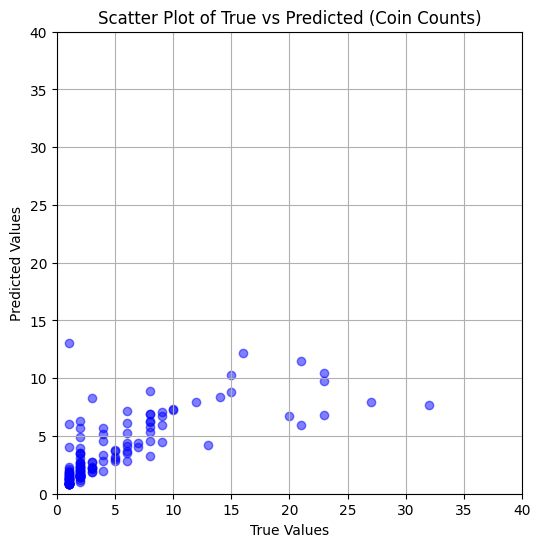

In [56]:
visualize_prediction(model)

## Experiments

### Random seed

| model        | layers       | mse_loss | rmse_loss |
|--------------|--------------|----------|-----------|
| v1           | 3 conv, 3 fc | 21.6     | 4.32      |
| v2           | 3 conv, 4 fc | 10.8     | 3.24      |
| v2 (2nd try) | 3 conv, 4 fc | 15.8     | 3.77      |
| v2 (3rd try) | 3 conv, 4 fc | 17.7     | 4.01      |

### Manual seed

| model        | seed | mse_loss | rmse_loss |
|--------------|------|----------|-----------|
| v1           | 0    | 74.23    | 5.90      |
| v2           | 0    | 18.77    | 4.11      |
| v1           | 4    | 6.71     | 2.52      |
| v2           | 4    | 9.65     | 2.76      |
| v1           | 99   | 11.72    | 3.23      |
| v2           | 99   | 13.73    | 3.55      |
| v1           | 2450 | 7.76     | 2.59      |
| v2           | 2450 | 7.26     | 2.46      |